In [1]:
import pyleoclim as pyleo
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from scipy.signal import find_peaks,peak_widths,peak_prominences
from statistics import mean
from scipy.optimize import linear_sum_assignment
import itertools

In [2]:
%matplotlib inline

In [3]:
import math

# Generates a signal with a gap and 20% deleted points

In [4]:
def generate_signal(gap_length,kind):
    freqs=[1/20,1/80]
    time=np.arange(2001)
    signals=[]
    for freq in freqs:
        signals.append(np.cos(2*np.pi*freq*time))
    signal=sum(signals)
    slope = 1e-5
    intercept = -1
    nonlinear_trend = slope*time**2 + intercept
    signal_trend = signal + nonlinear_trend
    sig_var = np.var(signal)
    noise_var = sig_var / 2 #signal is twice the size of noise
    white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
    signal_noise = signal_trend + white_noise
    nt = np.size(time)
    deleted_idx =None
    if kind=='even':
        deleted_idx = np.arange(nt//2-gap_length//2, nt//2+gap_length//2)
        #print(deleted_idx)
    else:
        start = 160
        end = end = start+gap_length
        deleted_idx = np.arange(start,end)
        
    
    signal_unevenly =  np.delete(signal_noise, deleted_idx)
    time_unevenly = np.delete(time,deleted_idx)
    n_del = math.floor(0.2*np.size(time))
    deleted_idx = np.random.choice(range(np.size(time_unevenly)), n_del, replace=False)
    signal_unevenly =  np.delete(signal_unevenly, deleted_idx)
    time_unevenly = np.delete(time_unevenly,deleted_idx)
    #print(len(signal_unevenly),len(time_unevenly))
    
        
   
    ts= pyleo.Series(time_unevenly,signal_unevenly)
    
    
    return ts
    
    #gap_length = [100,200,400,600,800]


# Divides the signal with gap into 2 segments

In [5]:
def segment(ts):
    ts_segment = ts.segment()
    return ts_segment

# Standardizes and detrends the signal

In [6]:
def preprocess(ts):
    ts_std = ts.standardize()
    ts_detrend = ts_std.detrend(method='emd')
    
    return ts_detrend
    

     
    

# Spectral Analysis with WWZ

In [7]:
def spectral(ts_segment):
   
    for ts in ts_segment.series_list:
        ts = preprocess(ts)
        #ts = interpolate(ts)
        psd_wwz = ts.spectral(method='wwz')
        psd_signif = psd_wwz.signif_test(qs=[0.95])
        amplitude= None
        for p in psd_signif.signif_qs.psd_list:
            amplitude = p.amplitude
        a,b,c = cost_function(psd_wwz.__dict__,[1/20,1/80],amplitude)
        print(a,b,c)
        fig, ax = psd_signif.plot(title='WWZ analysis')


# Cost Function to verify if correct  number of peaks are detected

In [8]:
def cost_function(res_psd,actual_freqs,signif_qs_psd_amplitude,dist_tol=0,peak_tol=0):
    #num_peaks= number of actual peaks in the frequency
    #tol = tolerance, if inaccuracy is less than tol, then return 0
    '''
    1. find all peaks
    2. calc cost function for num_peaks, find peaks closest to actual peak.
    3. 
    #rank by correct num peaks, distance, height/width ratio
    #try instead of adding distance, try normalized mean of distances
    '''
        
    correct_num_peaks=True
    peaks,h=find_peaks(res_psd['amplitude'],height=0)
    height_tol=peak_tol*mean(h['peak_heights'])

    prom,_,__=peak_prominences(res_psd['amplitude'],peaks)
    prom_thresh=mean(prom)*peak_tol
   
    peaks,props=find_peaks(res_psd['amplitude'],prominence=prom_thresh,height=height_tol)
    
   
    if len(peaks) < len(actual_freqs):
        correct_num_peaks=False       
    widths=np.array(peak_widths(res_psd['amplitude'],peaks,rel_height=0.99)[0])
    #only consider peaks clostest to actual freqs, need te do bipartite matching (using linear sum assignment func)
    #assignment problem between peaks and actual_freqs
    #create cost matrix, rows=peaks, cols= actual_freq, cost= dist
    temp_combs=np.array(list(itertools.product(res_psd['frequency'][peaks],actual_freqs)))
    #print(temp_combs)
    dist=lambda x,y:abs(x-y)
    optimum = []
    l = res_psd['frequency'][peaks]
   
    
    
            
    cost=dist(temp_combs[:,0],temp_combs[:,1]).reshape(-1,len(actual_freqs)) #rows = peak, 
    
    row_ind,col_ind=linear_sum_assignment(cost)
    
    dists=np.mean(cost[row_ind,col_ind],dtype=float)    
    peakidx=row_ind
    peak_amplitude = []
    detected_amplitude = []
    indexes = []
    #from the index finding the frequency closest to actual frequency of psd and then extracting the corresponding 
    # amplitude
   
    for idx in peakidx:
        
        indexes.append(np.where(res_psd['frequency']==l[idx])[0][0])
        x = np.where(res_psd['frequency']==l[idx])[0][0]
        peak_amplitude.append(res_psd['amplitude'][x])
    
    # extracting amplitude of 95% series at peak 
    for idx in indexes:
       
        detected_amplitude.append(signif_qs_psd_amplitude[idx])
    peak_heights=props['peak_heights'][peakidx]
    flag = True
    for i in range(len(peak_amplitude)):
        if peak_amplitude[i] < detected_amplitude[i]:
            flag = False
            break
   
   

    avg_height_width_ratio=mean([peak_height/widths[i] for i,peak_height in enumerate(peak_heights)])
    res = None
    if flag ==True and correct_num_peaks==True:
        res = 2
    elif flag==True and correct_num_peaks == False or flag==False and correct_num_peaks==True:
        res = 1
    else:
        res = 0

    #dist tol is an accuracy tolerance for distance of peak to actual freq
    if dists<dist_tol:
        dists=0
    return (correct_num_peaks,avg_height_width_ratio,res)

# Adding Gap close to edge

# Gap Length = 200

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [12:40<00:00,  3.80s/it]


True 4.945297606038473 1


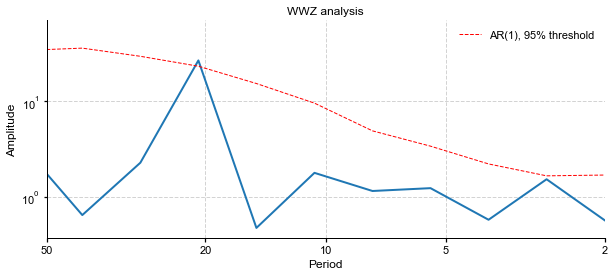

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [17:32<00:00,  5.26s/it]


True 16.5744480564245 2


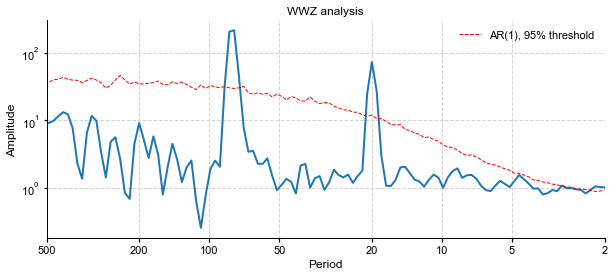

In [10]:
ts = generate_signal(200,'uneven')


ts_segment = segment(ts)

spectral(ts_segment)

# Gap Length = 400

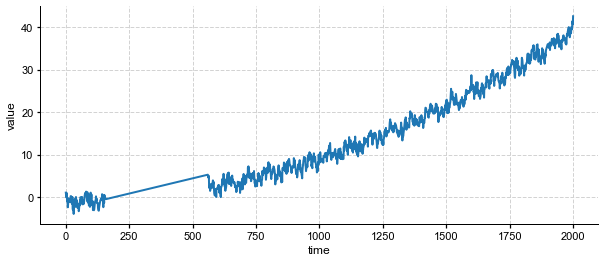

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [13:38<00:00,  4.09s/it]


True 6.351698186665756 1


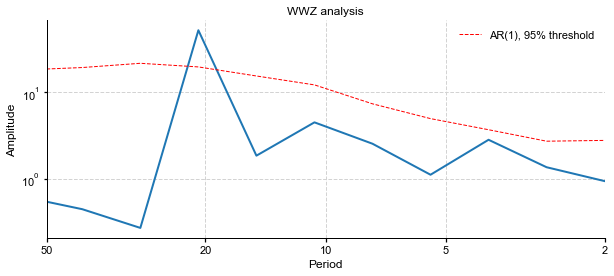

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [15:31<00:00,  4.66s/it]


True 18.90935653544737 2


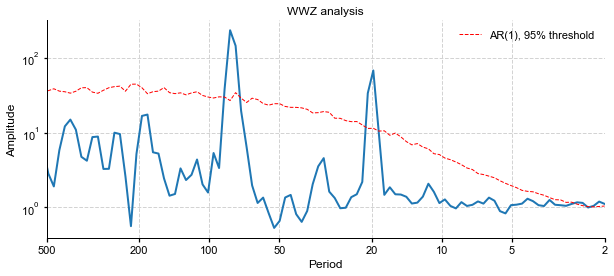

In [13]:
ts = generate_signal(400,'uneven')

ts.plot()
ts_segment = segment(ts)

spectral(ts_segment)

# Gap Length = 600

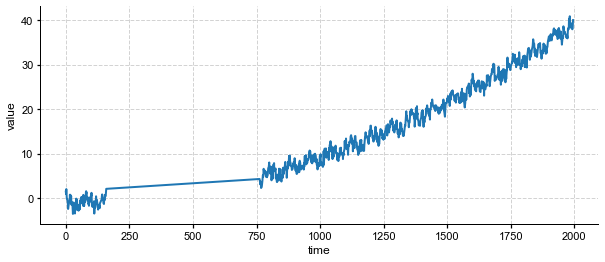

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [13:17<00:00,  3.99s/it]


True 3.062748291255873 1


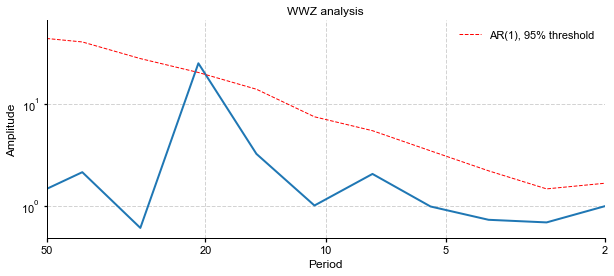

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [14:27<00:00,  4.34s/it]


True 18.65380137135363 2


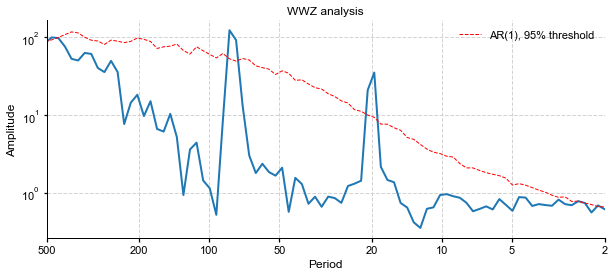

In [15]:
ts = generate_signal(600,'uneven')

ts.plot()
ts_segment = segment(ts)

spectral(ts_segment)

# Gap Length = 800

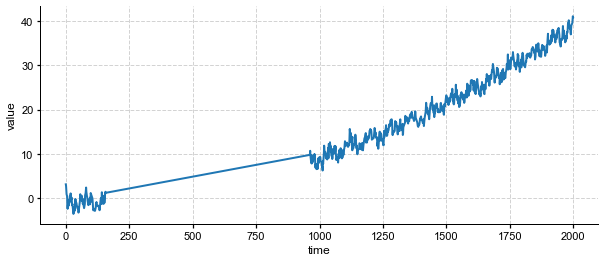

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [13:51<00:00,  4.16s/it]


True 1.3500873621241753 1


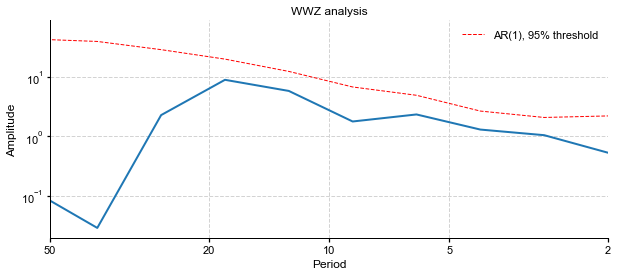

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [12:45<00:00,  3.83s/it]


True 24.347638402479095 2


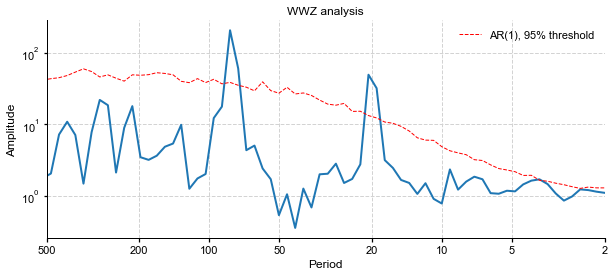

In [17]:
ts = generate_signal(800,'uneven')

ts.plot()
ts_segment = segment(ts)

spectral(ts_segment)